# 12. Portfolio backtesting

The first step is to activate the packages and load the data.

In [1]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
import xgboost as xgb
import datetime

np.random.seed(0)
from plotnine import *
from plotnine.data import *

In [3]:
#data_ml = pyreadr.read_r(insert path of data_ml.RData)["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)

data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)

We also copy/paste some chunks from Chapter 2.


In [4]:
stock_ids = data_ml.stock_id.unique() 
stock_days = data_ml.stock_id.value_counts().sort_index() 
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]

returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index=['date'],columns='stock_id',values='R1M_Usd')  
features = list(data_ml.columns[2:95]) 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]
data_ml['R1M_Usd_C'] = data_ml.R1M_Usd >  data_ml.groupby('date').R1M_Usd.transform('median')
data_ml['R12M_Usd_C'] = data_ml.R12M_Usd >  data_ml.groupby('date').R12M_Usd.transform('median')
separation_date = dt.strptime("2014-01-15","%Y-%m-%d")
training_sample = data_ml[data_ml.date < separation_date]
testing_sample = data_ml[data_ml.date  >= separation_date]

We split the backtest in four parts:   

1. the creation/initialization of variables;   
2. the definition of the strategies in one main functions;    
3. the backtesting loop itself;   
4. the performance indicators.    

Accordingly, we start with initializations. 

In [5]:
sep_oos = dt.strptime("2007-01-01","%Y-%m-%d")
ticks = data_ml['stock_id'].unique()
N = len(ticks)
t_oos = returns.index[returns.index>sep_oos].unique()
Tt = len(t_oos)
nb_port = 2
portf_weights = np.zeros((Tt, nb_port, N))
portf_returns = np.zeros((Tt, nb_port))

In the function below, all parameters (e.g., the learning rate, *eta* or the number of trees *nrounds*) are hard-coded. They can easily be passed in arguments next to the data inputs. One very important detail is that in contrast to the rest of the book, the label is the 12 month future return. Also, to speed up the computations, we remove the bulk of the distribution of the labels and keep only the top 20% and bottom 20%. The filtering levels could also be passed as arguments.


In [6]:
def weights_xgb(train_data, test_data, features):
    train_label = train_data.R12M_Usd / np.exp(train_data.Vol1Y_Usd)
    ind = np.logical_or(train_label> train_label.quantile(0.8)  ,  
                        train_label<train_label.quantile(0.2))
    train_features = train_data[features][ind]
    train_label = train_label[ind]
    fit_xgb = xgb.XGBRegressor(     
                  learning_rate  = 0.3,       #Boosting learning rate                  
                  objective = "reg:linear",   ##Specify the learning task and the corresponding learning objective or a custom objective function to be used         
                  max_depth = 4,              #Maximum tree depth for base learners.                              
                  n_estimators = 80,          #Number of trees in random forest to fit.           
                    )
    fit_xgb.fit(train_features,train_label )
    xgb_test = test_data[features]
    
    pred = fit_xgb.predict(xgb_test)
    w = pred > np.median(pred)
    w = pd.DataFrame(w / np.sum(w), columns=['weights'])
    w['names'] = test_data.stock_id.unique()
    return w
    
     


This function is then embedded in the global weighting function which only wraps two schemes: the EW benchmark and the ML-based policy.


In [7]:
def portf_compo(train_data, test_data, features, j):
    if j == 0:  ##
        N = len( test_data.stock_id.unique())
        w = [1/N] * N
        w = pd.DataFrame(w,columns=['weights'])
        w['names'] = test_data.stock_id.unique()
        return w
    if j == 1:  ###
        return weights_xgb(train_data, test_data, features)
    

Equipped with this function, we can turn to the main backtesting loop. Given the fact that we use a large scale model, the computation time for the loop is large (possibly a few hours on a slow machine with CPU). 


In [8]:
m_offset = 12
train_size = 5
for t in range(len(t_oos)-1):
    if t % 12 == 11:
        print(t_oos[t])
    train_data = data_ml[ (data_ml.date < (t_oos[t] - datetime.timedelta(days=m_offset * 30))) &  
                         (data_ml.date > (t_oos[t]  - datetime.timedelta(days= m_offset * 30 + 365 * train_size))) ]
    test_data = data_ml[data_ml.date == t_oos[t]]
    realized_returns = test_data.R1M_Usd
    for j in range(2):
        temp_weights = portf_compo(train_data, test_data, features, j)
        temp_ticks = list(ticks)
        ind  = [ temp_ticks.index(x) for x in temp_weights.names if x in ticks ]
               
        
        portf_weights[t,j,ind] = temp_weights.weights                                             # Allocate weights 
        portf_returns[t,j] = (np.array(temp_weights.weights) * np.array(realized_returns) ).sum() # Compute returns        
    

[02:41:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:41:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:41:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:41:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

[02:41:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

[02:42:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

[02:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
2012-12-31 00:00:00
[02:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/

[02:43:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
2014-12-31 00:00:00
[02:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/

[02:43:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
2016-12-31 00:00:00
[02:43:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/

[02:44:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:44:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


There are two important comments to be made on the above code. The first comment pertains to the two parameters that are defined in the first lines. They refer to the size of the training sample (5 years) and the length of the buffer period. This **buffer period is imperative** because the label is based on a long-term (12 month) return. This lag is compulsory to avoid any forward looking bias in the backtest. 


Below, we create a function that compute the turnover (variation in weights). It requires both the weight values as well as the returns of all assets because the weights just before a rebalancing depend on the weights assigned in the previous period as well as on the returns of the assets that have altered these original weights during the holding period. 


In [9]:
def turnover(weights, asset_returns, t_oos):
    turn = 0
    for t in range(1,length(t_oos)):
        realised_returns = returns[returns.date == t_oos[t]].loc[:, returns.columns !='date']
        prior_weights = weights[t-1] * (1 + realised_returns) 
        turn = turn +  abs(weights[t] - prior_weights/sum(prior_weights)).apply(lambda x: sum(x), axis =1)[0]
    return (turn/(length(t_oos)-1))


Once turnover is defined, we embed it into a function that computes several key indicators.


In [10]:
def perf_met(portf_returns, weights, asset_returns, t_oos):
    avg_ret = np.nanmean(portf_returns)
    vol = np.nanstd(portf_returns)
    Sharpe_ratio = avg_ret / vol
    VaR_5 = np.quantile(portf_returns, 0.05)
    turn = 0
    for t in range(1,len(weights)):
        realised_returns = asset_returns[asset_returns.index == t_oos[t]].loc[:]
        prior_weights = weights[t-1] * (1 + realised_returns) 
        turn = turn +  abs(weights[t] - prior_weights/sum(prior_weights)).apply(lambda x: sum(x), axis =1)[0]
    
    turn = turn / (len(t_oos) - 1)

    met = pd.DataFrame({'avg_ret': [avg_ret], 'vol': [vol], 'Sharpe_ratio':[Sharpe_ratio], 'VaR_5':[VaR_5], 'turn':[turn] })
    met.index = ["metrics"] * len(met)

    return met

Lastly, we build a function that loops on the various strategies. 


In [11]:
def perf_met_multi(portf_returns, weights, asset_returns, t_oos, strat_name):
    J = weights.shape[1]
    for j in range(J):
        if j==0:
            met = perf_met(portf_returns[:,j], weights[:,j], asset_returns, t_oos )
        else:
            met = met.append(perf_met(portf_returns[:,j], weights[:,j], asset_returns, t_oos ))
    met.index = strat_name 
    return met

Given the weights and returns of the portfolios, it remains to compute the returns of the assets to plug them in the aggregate metrics function. 


In [12]:
asset_returns = data_ml[['date','stock_id','R1M_Usd']]
asset_returns = asset_returns.pivot_table(index=['date'],columns='stock_id',values='R1M_Usd')
asset_returns = asset_returns.fillna(0)

met = perf_met_multi(portf_returns = portf_returns,  # Computes performance metrics
                      weights = portf_weights, 
                      asset_returns = asset_returns,
                      t_oos = t_oos,
                      strat_name = ["EW", "XGB_SR"]
                    )
met

,avg_ret,vol,Sharpe_ratio,VaR_5,turn
EW,0.009697,0.056233,0.172448,-0.077125,0.993006
XGB_SR,0.012597,0.063514,0.198335,-0.083359,0.993006


Finally, it is always tempting to plot the corresponding portfolio values. 


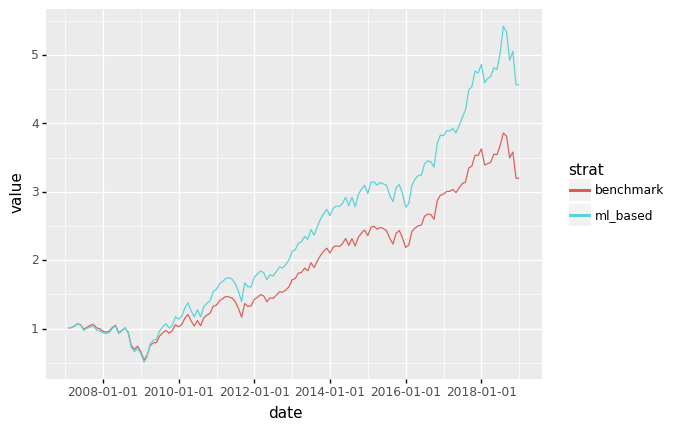

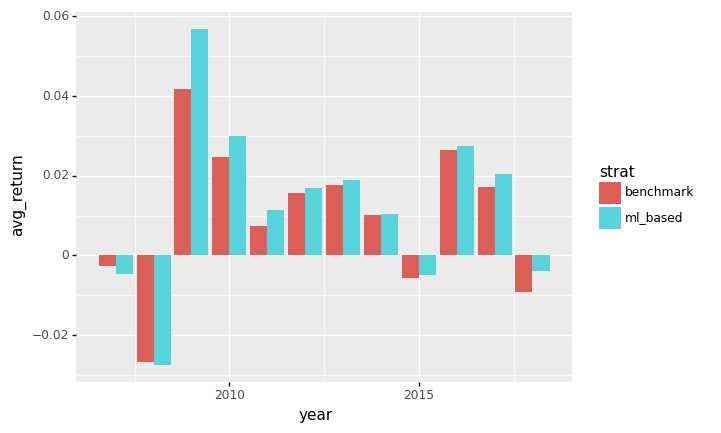

(<ggplot: (-9223371888006790270)>, <ggplot: (148856672225)>)

In [13]:
g1_df =  pd.DataFrame(zip(t_oos, 
                           np.cumprod(1+portf_returns[:,0]),
                           np.cumprod(1+portf_returns[:,1])), 
               columns =['date', 'benchmark','ml_based'])
g1 = pd.melt(g1_df, id_vars=['date'], value_vars=['benchmark', 'ml_based']).rename(columns={'variable': 'strat'})
g2_df = pd.DataFrame(zip(t_oos.year,
                        portf_returns[:,0],
                        portf_returns [:,1]),
                        columns =['year', 'benchmark','ml_based']) 
g2 = pd.melt(g2_df, id_vars=['year'], value_vars=['benchmark', 'ml_based']).rename(columns={'variable': 'strat'})
g2 = g2.groupby(['year','strat']).mean().rename(columns={"value":"avg_return"}).reset_index()

(
    ggplot(g1, aes(x='date', y='value', color='strat'))
    +  geom_line() + theme_grey(),
     ggplot(g2, aes(x='year', y='avg_return', fill='strat'))
    + geom_col(position = "dodge")  + theme_grey()  
)